# Data Pre-Processing

#### Import Packages and CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
data_url ="https://raw.githubusercontent.com/JunaidARahat/MyTutorials/main/insurance.csv"

df =pd.read_csv(data_url)

# Print shape of dataset
print(df.shape)

(1338, 7)


## Data Cleaning

### Handling Missing values

* Handling Missing values 
* Handling Duplicates
* Check data type
* Understand the dataset

#### Check Null Values

In [2]:
##Check features with nan value
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

* There is no null values in this dataset

### 3.2 Other Data Cleaning steps

**Handling Duplicates**

In [3]:
df.duplicated().sum()

1

* One duplicate column is found so we can drop it

In [4]:
df.drop_duplicates(inplace=True)

**Report**
* No Duplicates in the dataset.

# Feature Engineering

### Type of Features

**Numeric Features**

In [5]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 4


**Categorical Features**

In [6]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 3


**Discrete Features**

In [7]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 1


**Continues Features**

In [8]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 3


### Multicollinearity Check
#### Correllation Heatmap

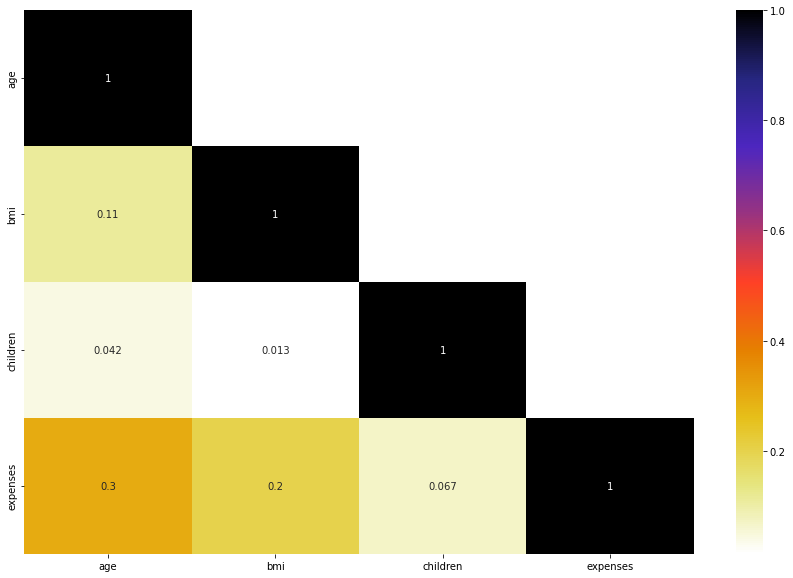

In [9]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), cmap="CMRmap_r", annot=True, mask= np.triu(df.corr(), k=1))
plt.show()

**Report** 
* No multicollinearity found

#### Variance Inflation Factor (VIF)

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [11]:
compute_vif(num_features, df)

,Variable,VIF
0,age,1.101407
1,bmi,1.044083
2,children,1.005075
3,expenses,1.136053


 ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable “ 
 
**- This Dataset Doesnt have any MultiCollinearity**

### Check Outlier and Capping it

**Why outliers?**
* Data Entry error : Human error. 
* Measurement error: Instrument error. 
* Natural error: it will be Real life data.
* Intentional error: People give wrong inputs

**Impact of Outliers ?**
* Ouliers can very high impact on few Machine learning models.
* Can Cause bias in the output.

**Why IQR For Outlier Handling?**
* For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.

* The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

* where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

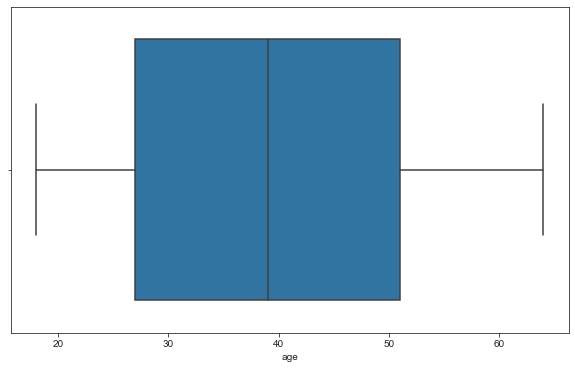

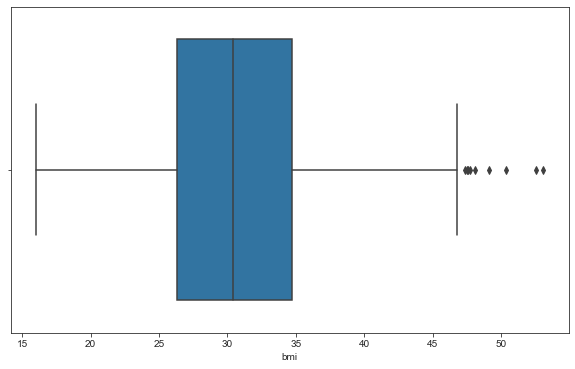

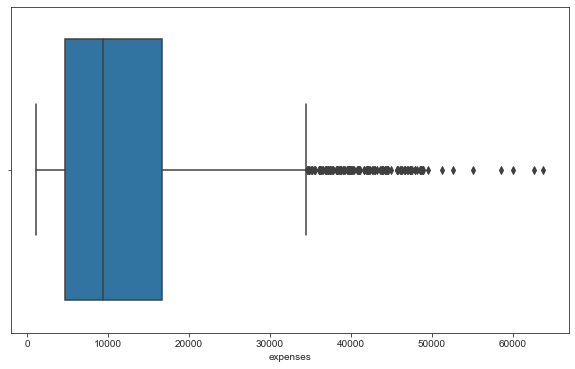

In [12]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

**Detecting Outlier and Capping it**

In [13]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df

**Why are we capping it and why not trim it ?**
* Trimming outliers may result in the removal of a large number of records from this dataset as we have already very less rows so this isn’t desirable in this case since columns other than the ones containing the outlier values may contain useful information.

* In this cases, you can use outlier capping to replace the outlier values with a maximum or minimum capped values. Be warned, this manipulates our data but we can replace outlier values by the upper and lower limit calculated using the IQR range.

In [14]:
for col in continuous_features:
         detect_outliers(col)


 #### age ####
percentile25 27.0
percentile75 51.0
Upper limit 87.0
Lower limit -9.0

 #### bmi ####
percentile25 26.3
percentile75 34.7
Upper limit 47.300000000000004
Lower limit 13.699999999999998

 #### expenses ####
percentile25 4746.34
percentile75 16657.72
Upper limit 34524.79
Lower limit -13120.73


**Checking Skewness after Outlier Capping**

In [15]:
df[continuous_features].skew(axis=0, skipna=True)

age         0.054781
bmi         0.233132
expenses    1.084698
dtype: float64

## Feature Transformation

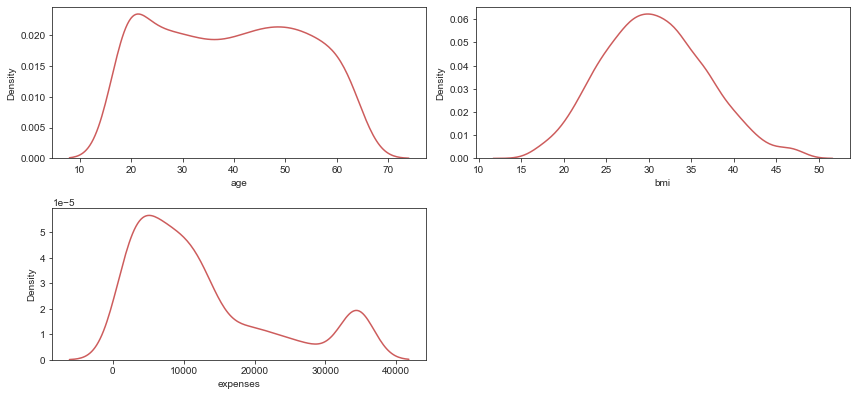

In [16]:
# distribution of data before scaling
plt.figure(figsize=(12, 8))
for i, col in enumerate(continuous_features):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(x=df[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

* After Capping Outlier it is all column's distribution is Normal so log transformation is not required.

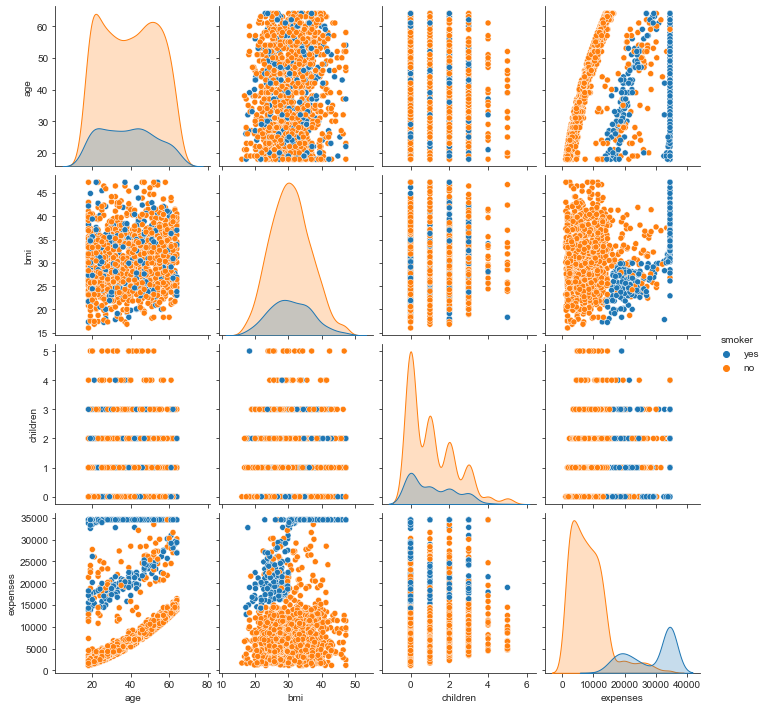

In [17]:
sns.pairplot(data=df,hue='smoker')

### Split X and Y

In [18]:
from sklearn.model_selection import train_test_split
X = df.drop(['expenses'], axis=1)
y = df['expenses']

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “ProdTaken” column.**


### Feature Selection

In [19]:
for feature in cat_features:
    print(feature,':', X[feature].nunique())

sex : 2
smoker : 2
region : 4


## Feature Encoding and Scaling

**One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Binary Encoder**
* To fight the curse of dimensionality, binary encoding might be a good alternative to one-hot encoding because it creates fewer columns when encoding categorical variables.

In [20]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include= "object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),
        
    ]
)

In [21]:
X= preprocessor.fit_transform(X)

## Train Test Split

* The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

* It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [22]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((1069, 11), (268, 11))

## Model Selection
* **Here should understand the Various Regression models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

**Import Required packages for model training**

In [23]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

#### Create a Function to Evaluate Model

In [24]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [25]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2 = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5235.9928
- Mean Absolute Error: 3432.1069
- R2 Score: 0.7252
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4590.7960
- Mean Absolute Error: 3163.1469
- R2 Score: 0.8196


Lasso
Model performance for Training set
- Root Mean Squared Error: 5234.1768
- Mean Absolute Error: 3429.9974
- R2 Score: 0.7254
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4573.5153
- Mean Absolute Error: 3152.4975
- R2 Score: 0.8210


Ridge
Model performance for Training set
- Root Mean Squared Error: 5234.2267
- Mean Absolute Error: 3434.7161
- R2 Score: 0.7253
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4576.6077
- Mean Absolute Error: 3160.1999
- R2 Score: 0.8208


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 4346.9834
- Mean Absolute Error: 2604.6032


**Results of All Models**

In [27]:
pd.DataFrame(list(zip(model_list, r2)), columns=["Model_name", "R2_score"]).sort_values(by=['R2_score'], ascending=False)

,Model_name,R2_score
7,CatBoosting Regressor,0.854920
5,Random Forest Regressor,0.846265
8,AdaBoost Regressor,0.846187
1,Lasso,0.820998
2,Ridge,0.820756
0,Linear Regression,0.819643
6,XGBRegressor,0.807902
3,K-Neighbors Regressor,0.775354
4,Decision Tree,0.733881


**Here we can use Random Forest , XGBoost Regressor, CatBoost Regressor and K-Neighbours Regressor for Hyper Parameter Tuning**

In [28]:
#Initialize few parameter for Hyperparamter tuning
rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

adaboost_params = {"learning_rate": [0.1, 0.01, 0.02, 0.06],
            "n_estimators": [100, 200, 300],
            "loss": ["linear", "square", "exponential"]
           }

cat_params = {"learning_rate": [0.1, 0.01, 0.06, 0.05],
              "max_depth": [6, 8, 12, 20, 30]}

In [29]:
# Models list for Hyperparameter tuning
randomcv_models = [("RF", RandomForestRegressor(), rf_params),
                   ('Adaboost', AdaBoostRegressor(), adaboost_params),
                   ('CatBoost', CatBoostRegressor(verbose=False), cat_params)
                   ]

In [30]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
---------------- Best Params for RF -------------------
{'n_estimators': 100, 'min_samples_split': 8, 'max_features': 7, 'max_depth': 5}
---------------- Best Params for Adaboost -------------------
{'n_estimators': 100, 'loss': 'exponential', 'learning_rate': 0.01}
---------------- Best Params for CatBoost -------------------
{'max_depth': 6, 'learning_rate': 0.01}


### Retraining the Model with best Parameters

In [31]:
models = {
    "Random Forest Regressor": RandomForestRegressor(**model_param['RF']),
    "AdaBoostRegressor": AdaBoostRegressor(**model_param['Adaboost']), 
     "CatBoosting Regressor": CatBoostRegressor(**model_param['CatBoost'] ,verbose=False)
}

model_list = []
r2_list = []


for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 4020.6270
- Mean Absolute Error: 2144.8985
- R2 Score: 0.8379
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 3750.6060
- Mean Absolute Error: 2048.9251
- R2 Score: 0.8796


AdaBoostRegressor
Model performance for Training set
- Root Mean Squared Error: 4338.5483
- Mean Absolute Error: 2680.3943
- R2 Score: 0.8113
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 3901.9551
- Mean Absolute Error: 2497.2365
- R2 Score: 0.8697


CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 3686.4801
- Mean Absolute Error: 1992.8900
- R2 Score: 0.8638
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 3868.0341
- Mean Absolute Error: 2192.6754
- R2 Score: 0.8720




## Results after Hyperparameter Tuning

In [32]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=["Model Name", "R2 Score"]).sort_values(by=["R2 Score"], ascending=False)

,Model Name,R2 Score
0,Random Forest Regressor,0.879618
2,CatBoosting Regressor,0.871962
1,AdaBoostRegressor,0.869707


### We can use Top two models in our pipeline